## Import libraries


In [253]:
### Matlab file to CSV Conversion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.svm import SVR
from scipy import signal, sparse 
from scipy.sparse.linalg import spsolve
from scipy.signal import argrelmax
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks, peak_prominences
from scipy.signal import chirp, find_peaks, peak_widths

### Matlab file to CSV Conversion


In [254]:
# #Matlab file to CSV Conversion

# data1 = loadmat("data/file/Y_new.mat")
# for i in data1:
#     if '__' not in i and 'readme' not in i:
#         np.savetxt(("data/file/Y_new.csv"),data1[i],delimiter=',')

# data2 = loadmat("data/file/Y_old.mat")        
# for j in data2:
#     if '__' not in j and 'readme' not in j:
#         np.savetxt(("data/file/Y_old.csv"),data2[j],delimiter=',')   


### Load CSV Data


In [255]:
### Load CSV Data
# rawX = pd.read_csv('data/previous_data/selective_data/x_merged.csv')
# rawY = pd.read_csv('data/previous_data/selective_data/y_merged.csv')

rawX = pd.read_csv('data/previous_data/selective_data/X_merged_selective.csv')
rawY = pd.read_csv('data/previous_data/selective_data/Y_merged_selective.csv')


### Preprocessing Training data


In [256]:
### Preprocessing Training data
#Apply 1st Gaussian   
gauss= gaussian_filter(rawX,sigma=0.5,cval=0.5, truncate=4.0)

def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z


#Baseline Correction ALS


asx =[]
Corrected_base =[]
for i in range(len(gauss)):
    asx.append(gauss[i].flatten())
    base=asx[i]-baseline_als(asx[i], 1000, 0.05)
    Corrected_base.append(base)

In [257]:
#Apply 2nd Gaussian      
gauss_2= gaussian_filter(Corrected_base,sigma=0.5,cval=0.5, truncate=4.0)


#Derivatives
signal_1stdev =[]
signal_2nddev =[]
smoothed_signal =[]

c=0
for i in range(len(gauss_2)):
    fstdev = (np.gradient(gauss_2[i]))
    signal_1stdev.append(fstdev)
    second_dev = np.gradient(fstdev)
    signal_2nddev.append(second_dev)
    sm_signal = gaussian_filter1d(second_dev, 2.4)
    smoothed_signal.append(sm_signal)
    c=c+1
    
    
    
#Peak Detection   
xpeak, _ = find_peaks(smoothed_signal[0], distance=1)
yheight = peak_prominences(smoothed_signal[0], xpeak)[0]

xpeak =[]
yheight =[]


for i in range(len(smoothed_signal)):
    peak, _ = find_peaks(smoothed_signal[i], distance=1)
    xpeak.append(peak)
    height=peak_prominences(smoothed_signal[i], peak)[0]
    yheight.append(height)

In [262]:
# rawX
# gauss
# Corrected_base
# gauss_2
# signal_1stdev
# signal_2nddev
# smoothed_signal
train =signal_1stdev

### Split Training data


In [263]:
X_train, X_test, y_train, y_test = train_test_split(train,rawY,test_size=0.25,shuffle=False)

###  Random Forrest Regression


In [264]:
###  Random Forrest Regression
regressor = RandomForestRegressor(n_estimators = 70, random_state = 8, max_features='auto', min_samples_leaf=6)                                
print(regressor.fit(X_train, y_train.values.ravel()),'\n\n')

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=6, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=8, verbose=0, warm_start=False) 




In [265]:
truey= y_test.values

prediction= regressor.predict(X_test)
rmse = np.sqrt(mean_squared_error(truey, prediction))
acc = r2_score(truey, prediction)               
               
print('Random Forrest Regression Test Results')
print('rmse_error',rmse)
print('Accuracy Score:' ,acc)

Random Forrest Regression Test Results
rmse_error 22.11170125235609
Accuracy Score: -0.4129736069130763


In [172]:
d1 = pd.DataFrame({'Real Values':truey.reshape(-1), 'Predicted Values':prediction})
#d1.to_csv("Random_Forrest_results.csv")

###  Support Vector  Regression


In [248]:
X_train, X_test, y_train, y_test = train_test_split(train,rawY,test_size=0.25,shuffle=False)
X = np.asarray(X_train)
y = np.asarray(y_train)
###  Support Vector  Regression

sc_X = StandardScaler()
sc_y = StandardScaler()


trainX = sc_X.fit_transform(X)
trainy = np.squeeze(sc_y.fit_transform(y))

In [249]:
testX = sc_X.fit_transform(np.asarray(X_test))
testy = np.squeeze(sc_y.fit_transform(np.asarray(y_test).reshape(-1, 1)))

In [252]:
regr = SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.5, gamma='auto',kernel='rbf', max_iter=-1, shrinking=True, tol=0.001)
print(regr.fit(trainX, trainy),'\n\n')


y_pred = regr.predict(testX)
y_pred = sc_y.inverse_transform(y_pred)


data_test = sc_y.inverse_transform(testy.reshape(-1))
svr_rmse = np.sqrt(mean_squared_error(data_test, y_pred))
svr_acc = r2_score(data_test, y_pred)               
               
print('Support Vector Machine Regression Results')
print('SVR rmse_error',svr_rmse)
print('SVR Accuracy Score:' ,svr_acc)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=1.3, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 


Support Vector Machine Regression Results
SVR rmse_error 21.321562707273547
SVR Accuracy Score: -0.313795583366685


In [132]:
df = pd.DataFrame({'Real Values':sc_y.inverse_transform(data_test.reshape(-1)), 'Predicted Values':y_pred})
#df.to_csv("SVR_results_new.csv")

In [ ]:
data_test

In [ ]:
y_pred

### Graph Plot


<IPython.core.display.Javascript object>


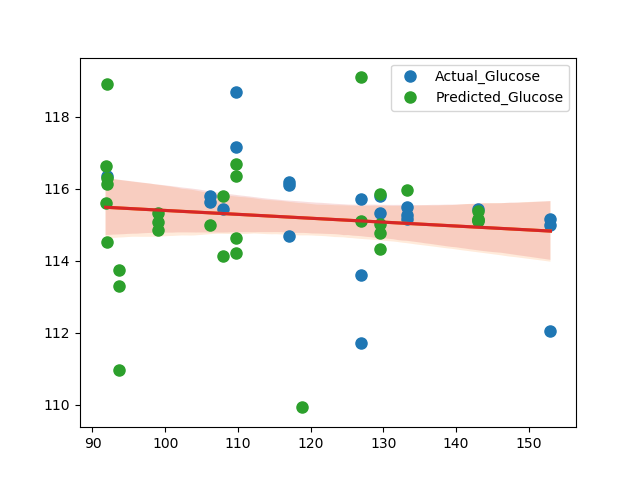

In [133]:
%matplotlib notebook
# Generate Datay_pred###  Support Vector  Regression

num = 52


x= data_test.flatten()
y= y_pred.flatten()

labels = np.random.choice(['Actual_Glucose', 'Predicted_Glucose'], num)
df = pd.DataFrame(dict(x=x, y=y, label=labels))

groups = df.groupby('label')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, label=name)
    ax = sns.regplot(x=x, y=y, data=df)
ax.legend()
plt.show()
#plt.savefig('data_mat/regression.png')

In [140]:
%matplotlib notebook
sns.histplot(data=df, x=x,  col=labels, multiple="dodge")
#sns.displot(df, x=x, hue=x, kind="kde", multiple="stack")

In [141]:
%matplotlib notebook
sns.histplot(data=df, x=y, hue=labels, multiple="dodge")